In [5]:
# pip install librosa

In [7]:
#pip install opencv-python

In [1]:
# #This is for STFT

# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import librosa
# import librosa.display
# from PIL import Image

# # Set the input and output directories
# gen_dir = "/Users/xaichotic/Library/CloudStorage/OneDrive-NorthumbriaUniversity-ProductionAzureAD/Term3/"

# input_folder = os.path.join(gen_dir, "Data_ALL/ECG/ECG_csv_files_labeled_baseline6_pantompkins")
# output_folder = os.path.join(gen_dir, "Data_ALL/ECG_images_baseline6_STFT")

# # Create output directory if it does not exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Define the parameters for the STFT
# n_fft = 1024
# hop_length = 512

# # Loop through all the CSV files in the folder
# for filename in os.listdir(input_folder):
#     if filename.endswith(".csv"):
#         # Load the CSV file as a NumPy array
#         file_path = os.path.join(input_folder, filename)
#         ecg_signal = pd.read_csv(file_path, header=None).values.flatten()

#         # Compute the STFT
#         stft = librosa.stft(ecg_signal, n_fft=n_fft, hop_length=hop_length)
#         stft_mag_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

#         # Normalize the STFT to [0, 1] range
#         stft_norm = (stft_mag_db - np.min(stft_mag_db)) / np.ptp(stft_mag_db)

#         # Convert the STFT to a 8-bit grayscale image
#         stft_img = (stft_norm * 255).astype(np.uint8)

#         # Save the image as a PNG file
#         output_filename = os.path.splitext(filename)[0] + ".png"
#         output_path = os.path.join(output_folder, output_filename)
#         Image.fromarray(stft_img, mode="L").save(output_path)

#         print(f"Processed {filename} and saved {output_filename}")


In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [1]:
#counting the length of the files EDA
#62, it matches the number of files in csv

gen_dir = "/Users/w20009829/OneDrive - Northumbria University - Production Azure AD/Term3/"

#setting the input and output directories
#gen_dir = "/Users/xaichotic/Library/CloudStorage/OneDrive-NorthumbriaUniversity-ProductionAzureAD/Term3/"

import os
folder_path = os.path.join(gen_dir, "Data_ALL/ECG_images_segment6_STFT")

#counting the number of files in the folder
num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f"There are {num_files} files in the {folder_path} folder.")


There are 81 files in the /Users/w20009829/OneDrive - Northumbria University - Production Azure AD/Term3/Data_ALL/ECG_images_segment6_STFT folder.


In [2]:
#checking for the frequency if each class

import os

data_dir = os.path.join(gen_dir, "Data_ALL/ECG_images_segment6_STFT")

class_counts = {0: 0, 1: 0}

for file_name in os.listdir(data_dir):
    if file_name.endswith(".png"):
        class_label = int(file_name.split("_")[-1].split(".")[0])
        class_counts[class_label] += 1

print(f"Class 0: {class_counts[0]} files")
print(f"Class 1: {class_counts[1]} files")

Class 0: 56 files
Class 1: 25 files


In [3]:
#extracting label from the filename

import cv2
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#setting the data directory path
data_dir = os.path.join(gen_dir, "Data_ALL/ECG_images_segment6_STFT")

X = []
y = []

#going through all the files in the directory
for file_name in os.listdir(data_dir):
    if file_name.endswith(".png"):
        # Extract the label from the file name
        label = int(file_name.split("_")[-1][0])
        #loading the image file and preprocess it
        file_path = os.path.join(data_dir, file_name)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        img = np.array(img).reshape(-1)
        #saving the preprocessed image and label in a list
        X.append(img)
        y.append(label)

#converting the data to numpy arrays
X = np.array(X)
y = np.array(y)

In [4]:
#splitting the data

from imblearn.under_sampling import RandomUnderSampler

#applying random under-sampling to the data
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [5]:
#printing the shape and class counts of the resampled data
print("Resampled data shape:", X_resampled.shape)
unique, counts = np.unique(y_resampled, return_counts=True)
print("Class counts:", dict(zip(unique, counts)))

Resampled data shape: (50, 50176)
Class counts: {0: 25, 1: 25}


In [6]:
#counting the number of instances for each class in the resampled training data
class_counts = np.bincount(y_resampled)
print("Class distribution after Random Undersampling:", class_counts)

Class distribution after Random Undersampling: [25 25]


In [7]:
#reshaping the data into a 4D tensor
X_train = X_train.reshape((-1, 224, 224, 1))
X_test = X_test.reshape((-1, 224, 224, 1))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40, 224, 224, 1)
(40,)
(10, 224, 224, 1)
(10,)


In [8]:
#tuned

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Bidirectional, LSTM, Reshape, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf

#setting the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

filter_size = 32
kernel_size = (2,2)
batch_size = 8
lstm_units = 32
neurons = 256

#defining the model architecture
model = Sequential()
model.add(Conv2D(filter_size, kernel_size, activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(filter_size*2, kernel_size, activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(filter_size*4, kernel_size, activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Reshape((-1, filter_size*4)))
model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dropout(0.5))
model.add(Dense(neurons, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(neurons*4, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#setting up early stopping
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, verbose=1, patience=5)

# Train the model with early stopping
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=batch_size, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 32)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 128)      0

1/1 [==============================] - 1s 676ms/step
[[0 3]
 [0 7]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.70      1.00      0.82         7

    accuracy                           0.70        10
   macro avg       0.35      0.50      0.41        10
weighted avg       0.49      0.70      0.58        10

Specificity: 0.0
ROC AUC: 0.380952380952381


C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


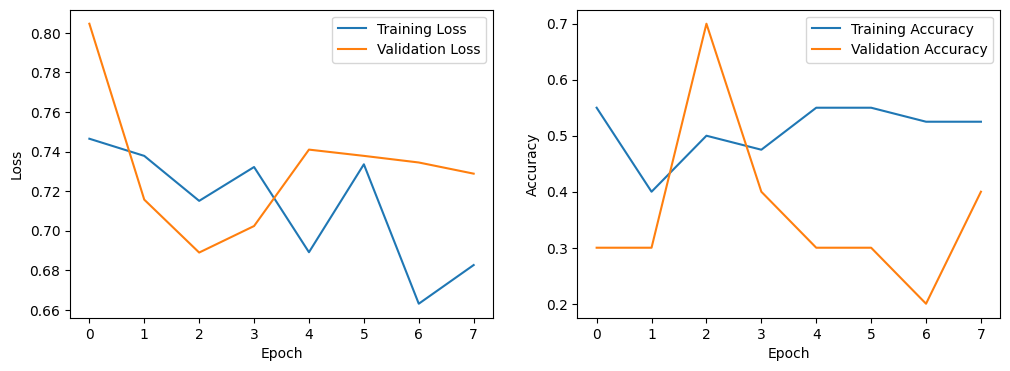

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

#getting the predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

#printing the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

#printing the classification report
print(classification_report(y_test, y_pred_classes))

#calculating specificity
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print('Specificity:', specificity)

#printing the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC AUC:', roc_auc)

import matplotlib.pyplot as plt

#getting the training and validation loss and accuracy values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#creating the figure and axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

#plotting the training and validation loss
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

#plotting the training and validation accuracy
ax2.plot(train_acc, label='Training Accuracy')
ax2.plot(val_acc, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

#showing the plot
plt.show()

cross-validation

In [10]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

#setting the random seeds for1reproducibility
np.random.seed(42)
tf.random.set_seed(42)

filter_size = 32
kernel_size = (2,2)
batch_size = 8
lstm_units = 32
neurons = 256
num_folds = 10
n_epochs = 20
neurons = 256


#defining the model architecture
def create_model():
    model = Sequential()
    model.add(Conv2D(filter_size, kernel_size, activation='relu', input_shape=(224, 224, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filter_size*2, kernel_size, activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filter_size*4, kernel_size, activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Reshape((-1, filter_size*4)))
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(Dropout(0.5))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(neurons*4, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

import random

#setting the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)

#K-fold cross-validation lists
score_list = []
precision_list = []
recall_list = []
f1_score_list = []
confusion_matrix_list = []
specificity_list = []
ROC_AUC_list = []


for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
    #splitting the data into train and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]
    
    #defining the early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    
    #training the model for this fold
    model = create_model()
    history = model.fit(X_train_fold, y_train_fold, epochs=n_epochs, batch_size=batch_size, 
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stop], verbose=1)
    
    #predicting the classes for the validation set for this fold
    y_pred = model.predict(X_val_fold)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    #calculating precision, recall, specificity, F1 score, AUC, and confusion matrix for this fold
    precision_list.append(precision_score(y_val_fold, y_pred_classes))
    recall_list.append(recall_score(y_val_fold, y_pred_classes))
    f1_score_list.append(f1_score(y_val_fold, y_pred_classes))
    #tp, fp, fn, tn = confusion_matrix(y_val_fold, y_pred_classes).ravel()
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_pred_classes).ravel()
    specificity = tn / (tn + fp)
    specificity_list.append(specificity)
    ROC_AUC_list.append(roc_auc_score(y_val_fold, y_pred))
    confusion_matrix_list.append(confusion_matrix(y_val_fold, y_pred_classes))

    #evaluating the model on the test set for this fold
    #_, test_acc = model.evaluate(X_test, y_test)
    _, test_acc = model.evaluate(X_val_fold, y_val_fold)

    score_list.append(test_acc)
    
    #printing the metrics and confusion matrix for this fold
    print(f'Fold {fold + 1}: Accuracy = {test_acc:.4f}, \
      Precision = {precision_list[-1]:.4f}, \
      Recall = {recall_list[-1]:.4f}, \
      Specificity = {specificity_list[-1]:.4f}, \
      AUC = {ROC_AUC_list[-1]:.4f}, \
      F1 Score = {f1_score_list[-1]:.4f}')
    print(f'Confusion matrix:\n{confusion_matrix_list[-1]}')
    
#printing the average scores for all folds

print(f'Average Accuracy: {np.mean(score_list):.4f} +/- {np.std(score_list):.4f}')
print(f'Average Precision: {np.mean(precision_list):.4f} +/- {np.std(precision_list):.4f}')
print(f'Average Recall/Sensitivity: {np.mean(recall_list):.4f} +/- {np.std(recall_list):.4f}')
print(f'Average Specificity: {np.mean(specificity_list):.4f} +/- {np.std(specificity_list):.4f}')
print(f'Average F1-score: {np.mean(f1_score_list):.4f} +/- {np.std(f1_score_list):.4f}')
print(f'Average ROC_AUC score: {np.mean(ROC_AUC_list):.4f} +/- {np.std(ROC_AUC_list):.4f}')

#printing the overall confusion matrix

overall_cm = np.sum(confusion_matrix_list, axis=0)
print(f'Overall confusion matrix:\n{overall_cm}')

Epoch 1/20
5/5 [==============================] - 5s 484ms/step - loss: 0.7421 - accuracy: 0.4444 - val_loss: 0.6323 - val_accuracy: 0.7500
Epoch 2/20
5/5 [==============================] - 1s 282ms/step - loss: 0.7446 - accuracy: 0.3889 - val_loss: 0.6795 - val_accuracy: 0.7500
Epoch 3/20
5/5 [==============================] - 1s 289ms/step - loss: 0.6748 - accuracy: 0.5833 - val_loss: 0.6550 - val_accuracy: 0.7500
Epoch 4/20
5/5 [==============================] - 1s 287ms/step - loss: 0.6915 - accuracy: 0.6111 - val_loss: 0.6143 - val_accuracy: 0.7500
Epoch 5/20
5/5 [==============================] - 1s 282ms/step - loss: 0.6911 - accuracy: 0.5556 - val_loss: 0.6407 - val_accuracy: 0.7500
Epoch 6/20
5/5 [==============================] - 1s 270ms/step - loss: 0.7192 - accuracy: 0.5556 - val_loss: 0.6412 - val_accuracy: 0.7500
Epoch 7/20
5/5 [==============================] - 1s 263ms/step - loss: 0.7381 - accuracy: 0.3889 - val_loss: 0.6573 - val_accuracy: 0.7500
Epoch 7: early stopp

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
5/5 [==============================] - 5s 402ms/step - loss: 0.7422 - accuracy: 0.4167 - val_loss: 0.6250 - val_accuracy: 0.7500
Epoch 2/20
5/5 [==============================] - 1s 257ms/step - loss: 0.7304 - accuracy: 0.4444 - val_loss: 0.6361 - val_accuracy: 0.7500
Epoch 3/20
5/5 [==============================] - 1s 265ms/step - loss: 0.6606 - accuracy: 0.6111 - val_loss: 0.6287 - val_accuracy: 0.7500
Epoch 4/20
5/5 [==============================] - 1s 264ms/step - loss: 0.7272 - accuracy: 0.4722 - val_loss: 0.6790 - val_accuracy: 0.7500
Epoch 4: early stopping
1/1 [==============================] - 0s 59ms/step - loss: 0.6250 - accuracy: 0.7500
Fold 2: Accuracy = 0.7500,       Precision = 0.0000,       Recall = 0.0000,       Specificity = 1.0000,       AUC = 0.3333,       F1 Score = 0.0000
Confusion matrix:
[[3 0]
 [1 0]]


C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
5/5 [==============================] - 5s 396ms/step - loss: 0.6504 - accuracy: 0.5833 - val_loss: 0.7138 - val_accuracy: 0.5000
Epoch 2/20
5/5 [==============================] - 1s 259ms/step - loss: 0.7872 - accuracy: 0.5278 - val_loss: 0.6972 - val_accuracy: 0.5000
Epoch 3/20
5/5 [==============================] - 1s 257ms/step - loss: 0.6941 - accuracy: 0.5556 - val_loss: 0.7005 - val_accuracy: 0.5000
Epoch 4/20
5/5 [==============================] - 1s 259ms/step - loss: 0.7215 - accuracy: 0.5833 - val_loss: 0.7277 - val_accuracy: 0.2500
Epoch 5/20
5/5 [==============================] - 1s 262ms/step - loss: 0.6828 - accuracy: 0.6389 - val_loss: 0.7200 - val_accuracy: 0.5000
Epoch 5: early stopping
1/1 [==============================] - 0s 71ms/step - loss: 0.6972 - accuracy: 0.5000
Fold 3: Accuracy = 0.5000,       Precision = 0.0000,       Recall = 0.0000,       Specificity = 1.0000,       AUC = 0.0000,       F1 Score = 0.0000
Confusion matrix:
[[2 0]
 [2 0]]


C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
5/5 [==============================] - 5s 402ms/step - loss: 0.6893 - accuracy: 0.4722 - val_loss: 0.7072 - val_accuracy: 0.5000
Epoch 2/20
5/5 [==============================] - 1s 269ms/step - loss: 0.7855 - accuracy: 0.3056 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 3/20
5/5 [==============================] - 1s 271ms/step - loss: 0.7109 - accuracy: 0.5000 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 4/20
5/5 [==============================] - 1s 262ms/step - loss: 0.7175 - accuracy: 0.5278 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
5/5 [==============================] - 1s 264ms/step - loss: 0.6816 - accuracy: 0.5278 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 6/20
5/5 [==============================] - 1s 263ms/step - loss: 0.6781 - accuracy: 0.5000 - val_loss: 0.6917 - val_accuracy: 0.5000
Epoch 7/20
5/5 [==============================] - 1s 261ms/step - loss: 0.7588 - accuracy: 0.5000 - val_loss: 0.6982 - val_accuracy: 0.5000
Epoch 8/20
5/5 [====

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
5/5 [==============================] - 5s 401ms/step - loss: 0.7474 - accuracy: 0.4722 - val_loss: 0.6870 - val_accuracy: 0.5000
Epoch 2/20
5/5 [==============================] - 1s 286ms/step - loss: 0.7031 - accuracy: 0.4167 - val_loss: 0.6863 - val_accuracy: 0.5000
Epoch 3/20
5/5 [==============================] - 1s 304ms/step - loss: 0.6839 - accuracy: 0.5278 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 4/20
5/5 [==============================] - 2s 309ms/step - loss: 0.7531 - accuracy: 0.5556 - val_loss: 0.6894 - val_accuracy: 0.5000
Epoch 5/20
5/5 [==============================] - 2s 308ms/step - loss: 0.6721 - accuracy: 0.5556 - val_loss: 0.6859 - val_accuracy: 0.7500
Epoch 6/20
5/5 [==============================] - 2s 307ms/step - loss: 0.7200 - accuracy: 0.5556 - val_loss: 0.6735 - val_accuracy: 0.5000
Epoch 7/20
5/5 [==============================] - 2s 307ms/step - loss: 0.7979 - accuracy: 0.3333 - val_loss: 0.6721 - val_accuracy: 0.5000
Epoch 8/20
5/5 [====

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
5/5 [==============================] - 5s 413ms/step - loss: 0.7179 - accuracy: 0.5278 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 2/20
5/5 [==============================] - 1s 261ms/step - loss: 0.6612 - accuracy: 0.5833 - val_loss: 0.7134 - val_accuracy: 0.5000
Epoch 3/20
5/5 [==============================] - 1s 265ms/step - loss: 0.6242 - accuracy: 0.5556 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 4/20
5/5 [==============================] - 1s 265ms/step - loss: 0.7313 - accuracy: 0.5556 - val_loss: 0.6898 - val_accuracy: 0.5000
Epoch 5/20
5/5 [==============================] - 1s 285ms/step - loss: 0.7610 - accuracy: 0.5000 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 6/20
5/5 [==============================] - 2s 313ms/step - loss: 0.7910 - accuracy: 0.4444 - val_loss: 0.6978 - val_accuracy: 0.5000
Epoch 7/20
5/5 [==============================] - 2s 315ms/step - loss: 0.7033 - accuracy: 0.5278 - val_loss: 0.6883 - val_accuracy: 0.5000
Epoch 8/20
5/5 [====

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
5/5 [==============================] - 5s 429ms/step - loss: 0.7186 - accuracy: 0.5278 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/20
5/5 [==============================] - 1s 288ms/step - loss: 0.7436 - accuracy: 0.3889 - val_loss: 0.6839 - val_accuracy: 0.5000
Epoch 3/20
5/5 [==============================] - 1s 288ms/step - loss: 0.7459 - accuracy: 0.3889 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 4/20
5/5 [==============================] - 1s 284ms/step - loss: 0.6451 - accuracy: 0.5833 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 5/20
5/5 [==============================] - 1s 287ms/step - loss: 0.7086 - accuracy: 0.5000 - val_loss: 0.6977 - val_accuracy: 0.5000
Epoch 5: early stopping
1/1 [==============================] - 0s 63ms/step - loss: 0.6839 - accuracy: 0.5000
Fold 10: Accuracy = 0.5000,       Precision = 0.5000,       Recall = 1.0000,       Specificity = 0.0000,       AUC = 0.7500,       F1 Score = 0.6667
Confusion matrix:
[[0 2]
 [0 2]]
Average 